### Creating an image classifier able to find sneakers in instagram posts

The data comprises of few thousand images of sneakers collected using google images and instagram
and few thousand images of sneakers.    
Your goal is to use what you learned from previous examples and create a sneaker-not-sneaker binary classifier.

The task comprises of multiple sub-tasks that you need to do to build the classifier.

1. Create a dataset able to load data from new_meta_sneakers.csv
2. Create a fine tune binary classification architecture.
3. Create a training loop and train your model.

![title](static/sneakers.png)


### On the bottom of the following cell you see the data you will work with

In [2]:
%matplotlib inline
from torch import nn
import easyimages
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from pretrainedmodels.models import resnet50
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
import numpy as np 
import matplotlib.pyplot as plt
import torch 
import pathlib
from imgaug import augmenters as iaa
import PIL


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [22]:
PATH_TO_SNEAKER_NOT_SNEAKER_DATASET = '/home/i008/small_sneaker_not_sneaker'
base_path = pathlib.Path(PATH_TO_SNEAKER_NOT_SNEAKER_DATASET)

classes = []
paths = []
for p in base_path.glob('*/*'):
    relative_path = p.relative_to(base_path)
    classes.append(str(relative_path.parent))
    paths.append(p)
    
df = pd.DataFrame({"tags": classes, "image_path": paths}).sample(frac=1).reset_index()
df.tags = df.tags.map({'sneaker': 1, 'nontsneaker': 0})
df.head()

corrupted = []
for p in df.image_path:
    try:
        PIL.Image.open(p)
    except:
        corrupted.append(p)
        print(p)

df = df[~df.image_path.isin(corrupted)]
print(df.shape)


/home/i008/small_sneaker_not_sneaker/sneaker/1238.jpg
/home/i008/small_sneaker_not_sneaker/sneaker/1136.jpg
(1998, 3)


/home/i008/anaconda3/envs/dl/lib/python3.7/site-packages/PIL/Image.py:2817: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


### Creating the torch Dataset.

First thing we need to do is create a dataset able to load our data. Since our metadata is stored in a csv file, our 
dataset should accept this file as a base source of what needs to be loaded.

Our dataset should also support augumentations and a "inference" mode wich disables them for predicting.


In [36]:

import PIL
from PIL import Image
import io
import requests
import torch
from torch.utils.data import Sampler


class OneClassImageClassificationDataset(Dataset):
    def __init__(self, annotations, image_transform, augmenter=None):
        """
        annotations is a pandas dataframe
        
        """
        super().__init__()
        self.annotations = annotations
        self.image_transform = image_transform
        self.augmenter = augmenter

    def __len__(self):
        """
        Return the length of the annotations dataframe
        """
        # your code here
        return len(self.annotations)

    def __getitem__(self, index):
        """
        Using methods you wrote:
        1 - load image from disk for given index  (self.load_from_disk)
        2 - transform image (self.image_transform)
        3 - Load target (self.load_target)
        return Xi, yi
        """
        
        # YOUR CODE HERE

        Xi = self.load_from_disk(index)
        
        if self.augmenter is not None:
            Xi = self.augment(self.augmenter, Xi)
                  
        Xi = self.image_transform(Xi)
        yi = self.load_target(index)
        return Xi, yi

    def load_to_pil(self, uri):
        """
        Write a helper function that uses PIL.Image to load a file and returns it
        """

        image_pil = Image.open(uri)
        image_pil = image_pil.convert("RGB")
        # image_pil = YOUR CODE HERE
        return image_pil


    def load_from_disk(self, index):
        """
        Loads an image from disk given a index.
        It gets the path of an image with the corresponding index from the metadata 
        It passes the URI to the self.load_to_pil and returns a PIL.Image
        """
        image_path = self.annotations.iloc[index]['image_path']
        #image_path = # YOUR CODE HERE
        return self.load_to_pil(image_path)

    def load_target(self, index):
        """
        This function should get the tag for a given index from the annotations dataframe
        You .iloc can become useful.    
        This methods should return, either a 0 or a 1.
        """
        
        #label = # YOUR CODE HERE
        label = self.annotations.iloc[index]['tags']

        return label
    
    def augment(self, augmenter, image):
        augmenter = augmenter.to_deterministic()
        img_aug = augmenter.augment_image(np.array(image))
        img_aug = Image.fromarray(img_aug)
        return img_aug

    
class BaseSampler(Sampler):
    def __init__(self, df, n_samples):
        self.df = df
        self.n_samples = n_samples
        
    def __iter__(self):
        return iter(self._get_sample())
        
    def __len__(self):
        return self.n_samples
    
    def _get_sample(self):
        return np.random.choice(len(self.df), self.n_samples, replace=False)
        

def binary_classification_model():
    """
    Write a function that loads a resnet50 model from pretrainedmodels, freezes its layers
    replaces the last_linear with the proper output number. As we did in previous example.
    replace avgpool with adaptiv pooling.
    """
    model = resnet50()
    for p in model.parameters():
        p.requires_grad = False
    inft = model.last_linear.in_features
    model.last_linear = nn.Linear(in_features=inft, out_features=2)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    
    # model = YOUR CODE HERE
    return model


from imgaug import augmenters as iaa

aug_seq = iaa.Sequential([
    iaa.Fliplr(p=0.5),
    iaa.Sometimes(
        0.3,
        iaa.Multiply((0.9, 1.2))
    ),
    iaa.Sometimes(
        0.3,
        iaa.AdditiveGaussianNoise()
    ),
    iaa.Affine(
        scale=(0.5, 2),
        translate_percent=(-0.2, 0.2)
    )
])
def augment(self, augmenter, image):
    augmenter = augmenter.to_deterministic()
    img_aug = augmenter.augment_image(np.array(image))
    img_aug = Image.fromarray(img_aug)
    return img_aug



def binary_classification_model():
    """
    Write a function that loads a resnet50 model from pretrainedmodels, freezes its layers
    replaces the last_linear with the proper output number. As we did in previous example.
    replace avgpool with adaptiv pooling.
    """
    model = resnet50()
    for p in model.parameters():
        p.requires_grad = False
    inft = model.last_linear.in_features
    model.last_linear = nn.Linear(in_features=inft, out_features=2)
    model.avgpool = nn.AdaptiveAvgPool2d(1)
    
    # model = YOUR CODE HERE
    return model

# YOUR CODE HERE:
# SPLIT the dataframe into df_train, df_test (thing about using sklearn.model_selection.train_test_split)
df_train, df_test = train_test_split(df, train_size=0.75)
df_train = df_train.reset_index()
df_test = df_test.reset_index()

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
N_EPOCHS = 20
BATCH_SIZE = 16
IMAGE_SIZE = 256

image_transform_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

# YOUR CODE define image_transform_test
image_transform_test = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)])

# YOUR CODE define the crieterion
criterion = nn.CrossEntropyLoss()

net = binary_classification_model()

optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)


# YOUR CODE
# Instantiate the OneClassImageClassificationDatasets
train_ds = OneClassImageClassificationDataset(df_train, image_transform=image_transform_train, augmenter=aug_seq)
test_ds = OneClassImageClassificationDataset(df_test, image_transform=image_transform_test)

# initialize the BaseSampler
bs = BaseSampler(train_ds, 200)

#YOUR CODE
# Initialize your DataLoader (using datasets)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=bs)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE)


In [37]:
def evaluate_model(model, loader, print_info=False):
    with torch.no_grad():
        model.eval()
        collect_results = []
        collect_target = []
        for batch in loader:
            X, y = batch
            X = X.to(DEVICE)
            y = y.to(DEVICE).detach().cpu().numpy()
            pred = model(X)
            collect_results.append(pred.sigmoid().detach().cpu().numpy())
            collect_target.append(y) 
            
        preds_proba = np.concatenate(collect_results)
        preds = preds_proba.argmax(axis=1)
        targets = np.concatenate(collect_target)
        ll = log_loss(targets, preds_proba)
        acc = accuracy_score(targets, preds)
        if print_info:
            print("test log-loss: {}".format(ll))
            print("overall accuracy:  {}".format(acc))
            #print(classification_report(targets, preds))
        model.train()
        
        return ll, acc
    
metrics = []
metrics_names = ['loss_train','loss_test','acc_train','acc_test']
losses = []
net.to(DEVICE)

for epoch in range(N_EPOCHS):
    print(epoch)
    for X, y in train_dl:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        optimizer.zero_grad()
        ypred=net(X)
        loss = criterion(ypred, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        
    testll, testacc = evaluate_model(net, test_dl)
    trainll, trainacc = evaluate_model(net, train_dl)
    print("test: loss={} acc={}".format(testll, testacc))
    print("train: loss={} acc={}".format(trainll, trainacc))
    metrics.append([trainll, testll, trainacc, testacc])
        

0
test: loss=0.6209805178046226 acc=0.71
train: loss=0.6313114179670811 acc=0.645
1
test: loss=0.5667331109046936 acc=0.84
train: loss=0.572395155876875 acc=0.85
2
test: loss=0.5233384937644004 acc=0.856
train: loss=0.5137611630558968 acc=0.9
3
test: loss=0.49799248892068865 acc=0.858
train: loss=0.5142734788358212 acc=0.855
4
test: loss=0.48392712843418123 acc=0.85
train: loss=0.4960554937273264 acc=0.85
5
test: loss=0.4746434035599232 acc=0.842
train: loss=0.44901791878044606 acc=0.87
6
test: loss=0.4533298978507519 acc=0.882
train: loss=0.47167362313717603 acc=0.85
7
test: loss=0.452455320134759 acc=0.88
train: loss=0.4491221667081118 acc=0.885
8


KeyboardInterrupt: 

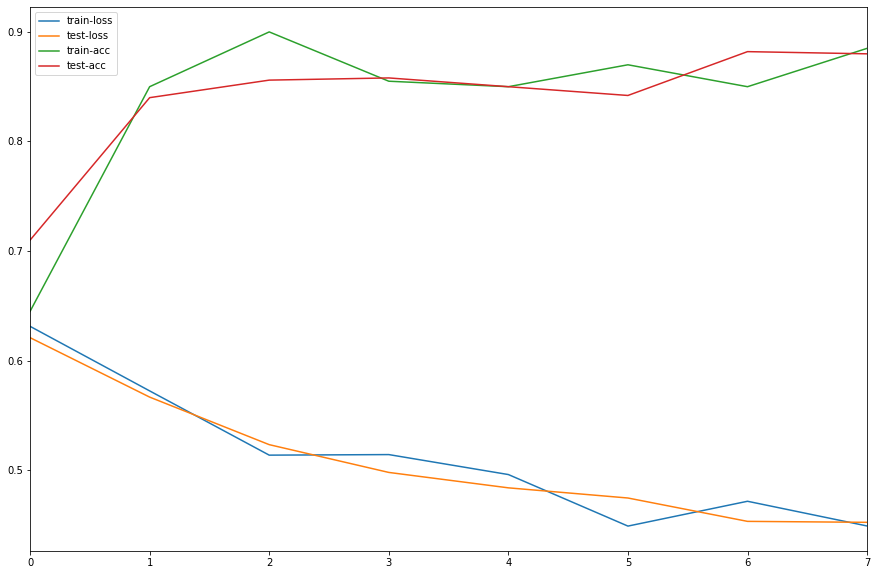

In [38]:
# plt.figure(figsize=(15,10))
pd.DataFrame(metrics, columns=['train-loss','test-loss','train-acc','test-acc']).plot(subplots=False, figsize=(15,10))

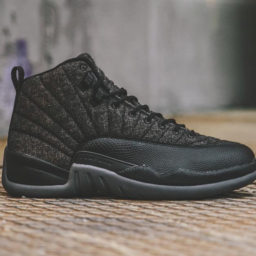

In [67]:
# pd.DataFrame(losses).plot()
# print(ypred.argmax(1))
# print(y)

import easyimages

easyimages.EasyImage.from_torch(X[2].cpu(),mean=MEAN, std=STD).image

###  Exercise ideas

1) Write a different Sampler for example one that will oversample the sneaker class by a factor of 3.